# Data Visualization


### **Introduction**

This notebook focuses on **exploratory data analysis (EDA)** of the IBM Telco Customer Churn dataset. The goal is to understand customer demographics, account information, subscribed services, and billing patterns, and how these factors relate to churn behavior.

By visualizing these relationships, we can:

* Identify patterns and trends in customer behavior.
* Highlight key differences between churned and retained customers.
* Generate business insights that can guide retention strategies.

This analysis does not cover predictive modeling. Instead, it provides the **descriptive and diagnostic foundation** that supports later machine learning work.

---


## Load packages 

In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)


In [21]:
data=pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [3]:
print("Dataset shape:", data.shape)
print("\nData types:\n", data.dtypes)
print("\nMissing values:\n", data.isnull().sum().sum())

Dataset shape: (7043, 21)

Data types:
 customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

Missing values:
 0


In [4]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
data.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [6]:
for col in data.select_dtypes(include='object').columns:
    print(f"{col}: {data[col].nunique()} unique values")

customerID: 7043 unique values
gender: 2 unique values
Partner: 2 unique values
Dependents: 2 unique values
PhoneService: 2 unique values
MultipleLines: 3 unique values
InternetService: 3 unique values
OnlineSecurity: 3 unique values
OnlineBackup: 3 unique values
DeviceProtection: 3 unique values
TechSupport: 3 unique values
StreamingTV: 3 unique values
StreamingMovies: 3 unique values
Contract: 3 unique values
PaperlessBilling: 2 unique values
PaymentMethod: 4 unique values
TotalCharges: 6531 unique values
Churn: 2 unique values


#### **Data Preprocessing Steps:**

* Drop irrelevant column: `customerID`.
* Convert `TotalCharges` to numeric and handle missing values.
* Encode target `Churn` as 0/1.
* Encode categorical features:

  * Binary (Yes/No → 0/1).
  * Multi-class (one-hot encoding).
* Scale numerical features: `tenure`, `MonthlyCharges`, `TotalCharges`.

In [14]:
# Missing values analysis
total = data.isnull().sum().sort_values(ascending = False)
percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).transpose()
print("\nMissing Values :\n",total)
# Check for duplicates
print(data.duplicated().any())


Missing Values :
 customerID          0
DeviceProtection    0
TotalCharges        0
MonthlyCharges      0
PaymentMethod       0
PaperlessBilling    0
Contract            0
StreamingMovies     0
StreamingTV         0
TechSupport         0
OnlineBackup        0
gender              0
OnlineSecurity      0
InternetService     0
MultipleLines       0
PhoneService        0
tenure              0
Dependents          0
Partner             0
SeniorCitizen       0
Churn               0
dtype: int64
False


In [22]:
#1. Drop Useless Columns
data = data.drop(['customerID'], axis=1)

#2.fix colomn types
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
data = data.dropna(subset=['TotalCharges'])

#3. Encode Target Variable
data['Churn'] = data['Churn'].map({'Yes': 1, 'No': 0})

#4. Encode Categorical Features
binary_cols = ['Partner','Dependents','PhoneService','PaperlessBilling',
               'MultipleLines','OnlineSecurity','OnlineBackup',
               'DeviceProtection','TechSupport','StreamingTV','StreamingMovies']

# unify "No internet service" and "No phone service"
for col in binary_cols:
    data[col] = data[col].replace({'No internet service':'No', 'No phone service':'No'})

# map to 0/1
for col in binary_cols:
    data[col] = data[col].map({'Yes':1, 'No':0})

# gender to 0/1
data['gender'] = data['gender'].map({'Female':1, 'Male':0})

# Multi-class categories
#data = pd.get_dummies(data, columns=['InternetService','Contract','PaymentMethod'], drop_first=True)

In [16]:
data.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,MonthlyCharges,TotalCharges,Churn,InternetService_Fiber optic,InternetService_No,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,0,1,0,1,0,0,0,1,0,...,29.85,29.85,0,False,False,False,False,False,True,False
1,0,0,0,0,34,1,0,1,0,1,...,56.95,1889.50,0,False,False,True,False,False,False,True
2,0,0,0,0,2,1,0,1,1,0,...,53.85,108.15,1,False,False,False,False,False,False,True
3,0,0,0,0,45,0,0,1,0,1,...,42.30,1840.75,0,False,False,True,False,False,False,False
4,1,0,0,0,2,1,0,0,0,0,...,70.70,151.65,1,True,False,False,False,False,True,False


### 1. Target Variable (Churn Distribution)

C:\Users\sarah\AppData\Local\Temp\ipykernel_14572\1232359209.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




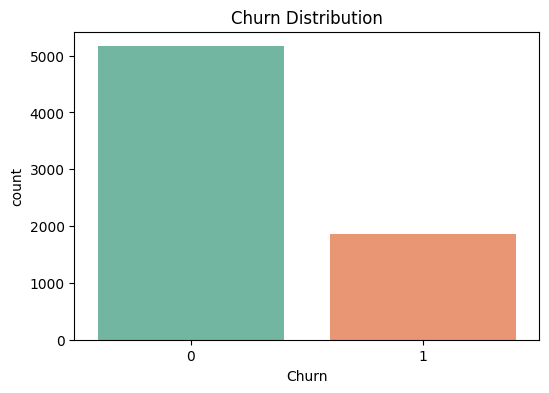

Churn
0    73.421502
1    26.578498
Name: proportion, dtype: float64


In [23]:
plt.figure(figsize=(6,4))
sns.countplot(x='Churn', data=data, palette='Set2')
plt.title("Churn Distribution")
plt.show()

# Percentages
print(data['Churn'].value_counts(normalize=True) * 100)


### 2. Customer Demographics
Bar plots:

gender vs Churn

SeniorCitizen vs Churn

Partner / Dependents vs Churn
→ Check if demographics correlate with higher churn.

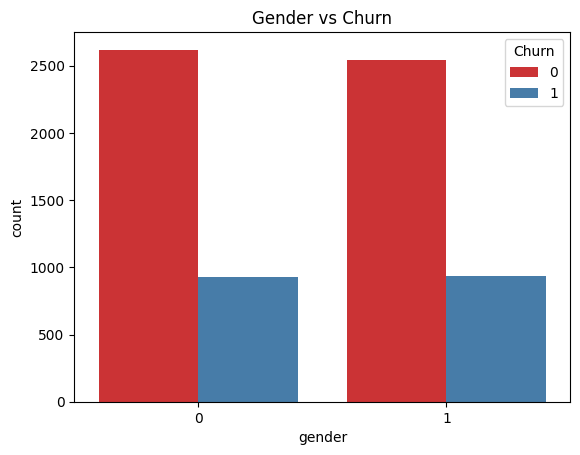

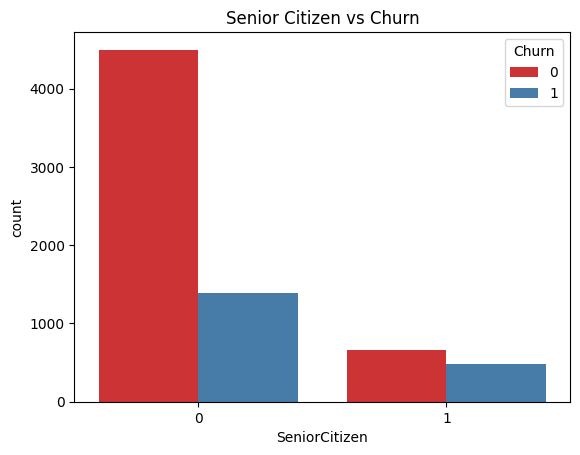

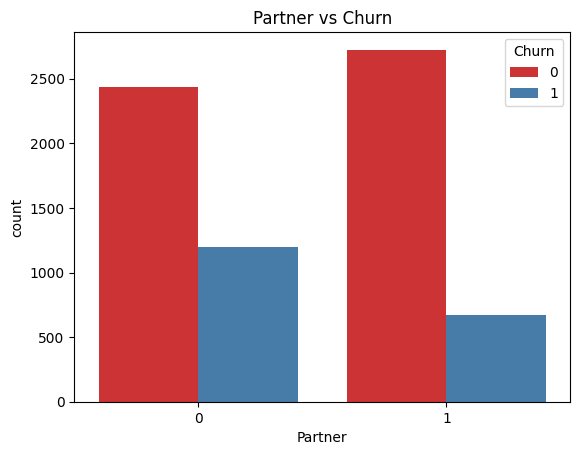

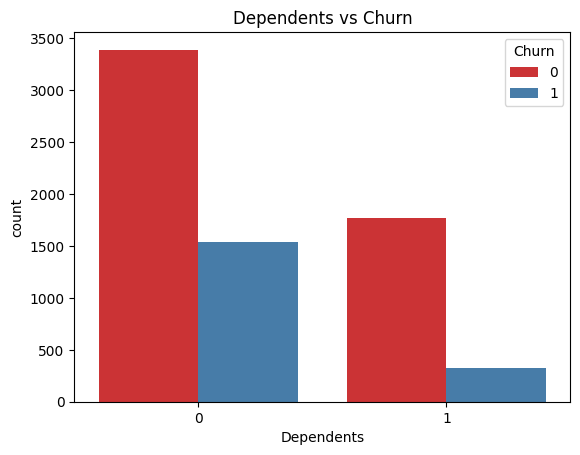

In [24]:
# Gender vs Churn
sns.countplot(x='gender', hue='Churn', data=data, palette='Set1')
plt.title("Gender vs Churn")
plt.show()

# Senior Citizen vs Churn
sns.countplot(x='SeniorCitizen', hue='Churn', data=data, palette='Set1')
plt.title("Senior Citizen vs Churn")
plt.show()

# Partner vs Churn
sns.countplot(x='Partner', hue='Churn', data=data, palette='Set1')
plt.title("Partner vs Churn")
plt.show()

# Dependents vs Churn
sns.countplot(x='Dependents', hue='Churn', data=data, palette='Set1')
plt.title("Dependents vs Churn")
plt.show()


### 3. Account Information

Bar plots:

Contract vs Churn

PaperlessBilling vs Churn

PaymentMethod vs Churn
→ These show retention risks tied to billing/contract terms.

Histogram / KDE:

tenure distribution split by churn.
→ Customers with short tenure usually churn more.

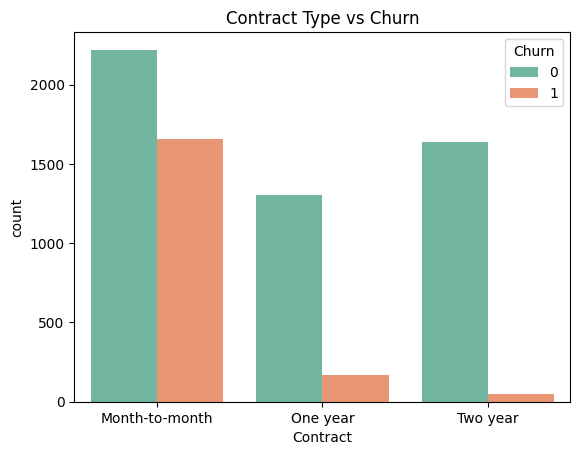

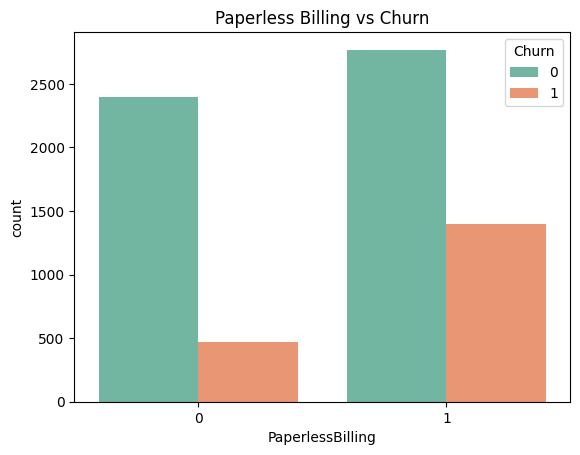

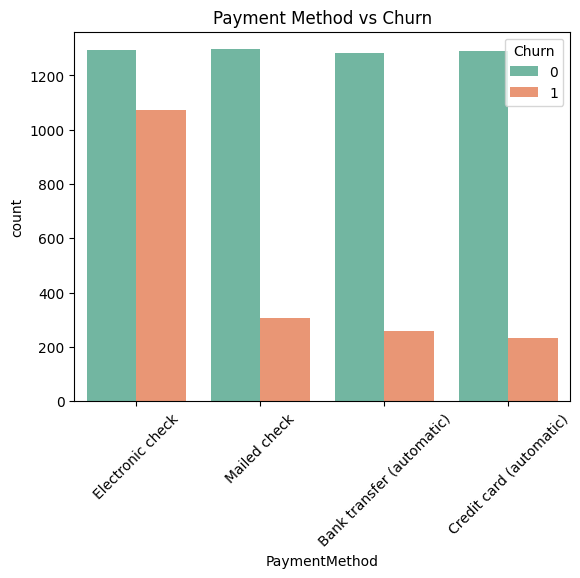

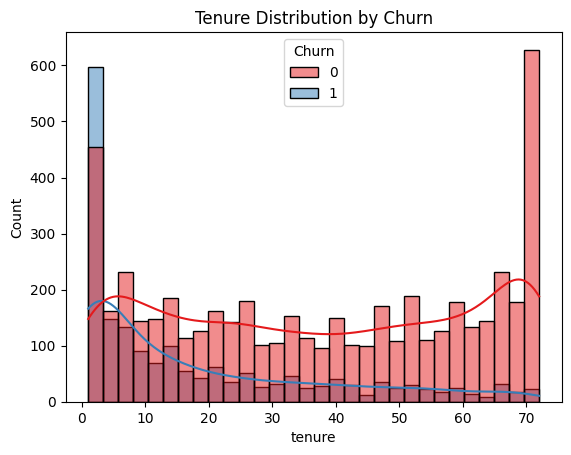

In [25]:
# Contract vs Churn
sns.countplot(x='Contract', hue='Churn', data=data, palette='Set2')
plt.title("Contract Type vs Churn")
plt.show()

# Paperless Billing vs Churn
sns.countplot(x='PaperlessBilling', hue='Churn', data=data, palette='Set2')
plt.title("Paperless Billing vs Churn")
plt.show()

# Payment Method vs Churn
sns.countplot(x='PaymentMethod', hue='Churn', data=data, palette='Set2')
plt.title("Payment Method vs Churn")
plt.xticks(rotation=45)
plt.show()

# Tenure distribution by Churn
sns.histplot(data=data, x='tenure', hue='Churn', bins=30, kde=True, palette='Set1')
plt.title("Tenure Distribution by Churn")
plt.show()


### 4. Services Subscribed


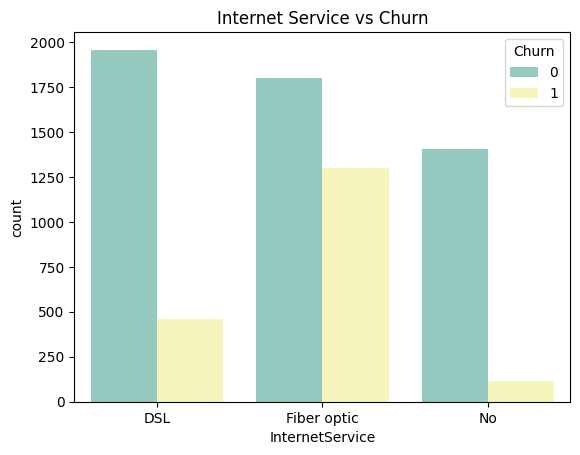

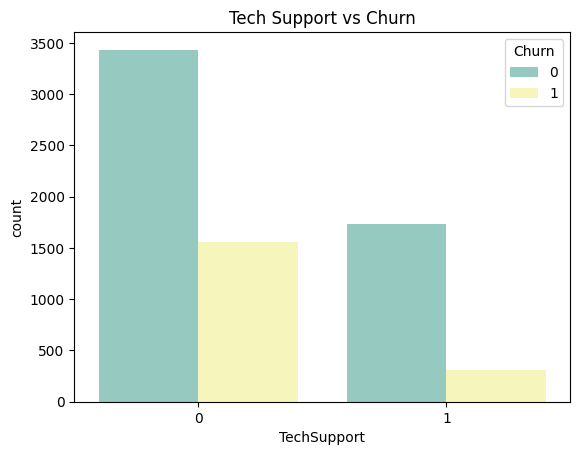

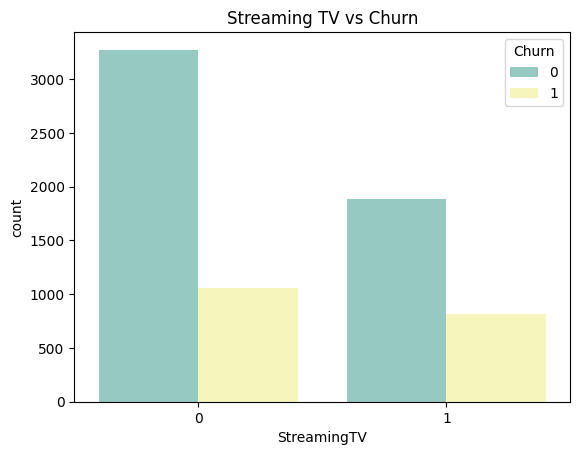

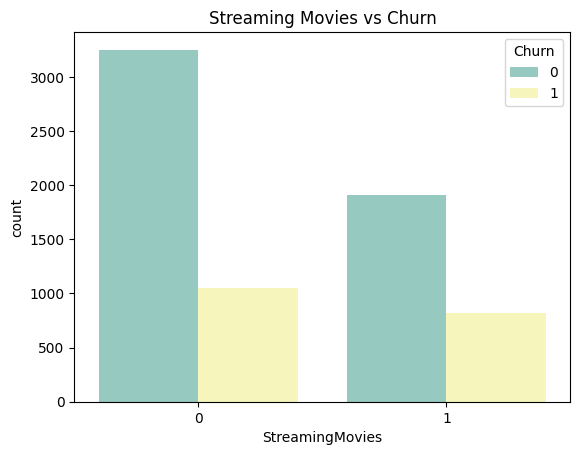

In [26]:
# Internet Service vs Churn
sns.countplot(x='InternetService', hue='Churn', data=data, palette='Set3')
plt.title("Internet Service vs Churn")
plt.show()

# Tech Support vs Churn
sns.countplot(x='TechSupport', hue='Churn', data=data, palette='Set3')
plt.title("Tech Support vs Churn")
plt.show()

# Streaming TV vs Churn
sns.countplot(x='StreamingTV', hue='Churn', data=data, palette='Set3')
plt.title("Streaming TV vs Churn")
plt.show()

# Streaming Movies vs Churn
sns.countplot(x='StreamingMovies', hue='Churn', data=data, palette='Set3')
plt.title("Streaming Movies vs Churn")
plt.show()


### 5. Billing & Charges

C:\Users\sarah\AppData\Local\Temp\ipykernel_14572\2060466649.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




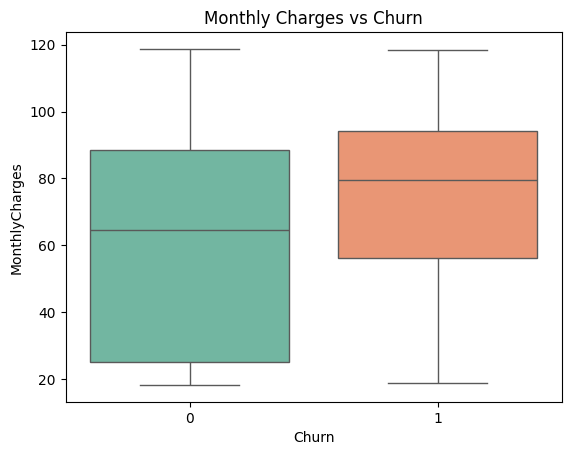

C:\Users\sarah\AppData\Local\Temp\ipykernel_14572\2060466649.py:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




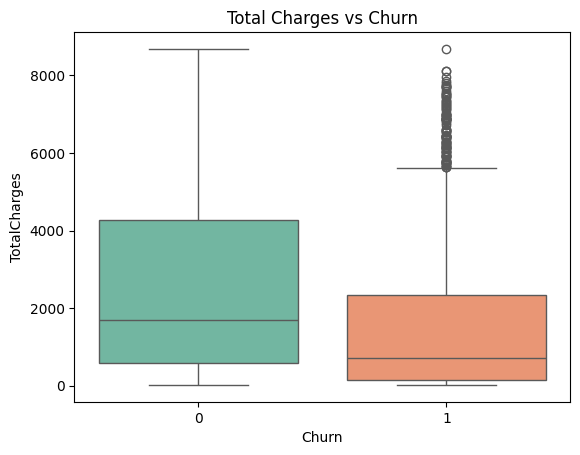

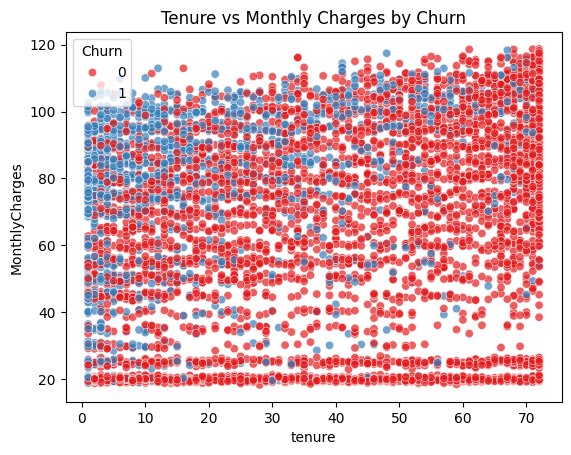

In [27]:
# Monthly Charges vs Churn
sns.boxplot(x='Churn', y='MonthlyCharges', data=data, palette='Set2')
plt.title("Monthly Charges vs Churn")
plt.show()

# Total Charges vs Churn
sns.boxplot(x='Churn', y='TotalCharges', data=data, palette='Set2')
plt.title("Total Charges vs Churn")
plt.show()

# Scatter: Tenure vs Monthly Charges colored by Churn
sns.scatterplot(x='tenure', y='MonthlyCharges', hue='Churn', data=data, alpha=0.7, palette='Set1')
plt.title("Tenure vs Monthly Charges by Churn")
plt.show()


### 6. Correlation / Heatmap

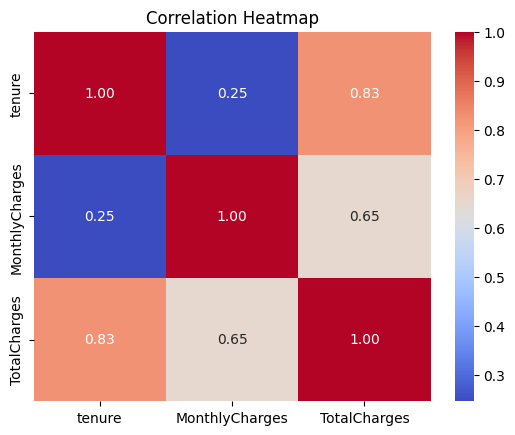

In [28]:
# Only numeric columns
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
corr = data[numeric_cols].corr()

sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


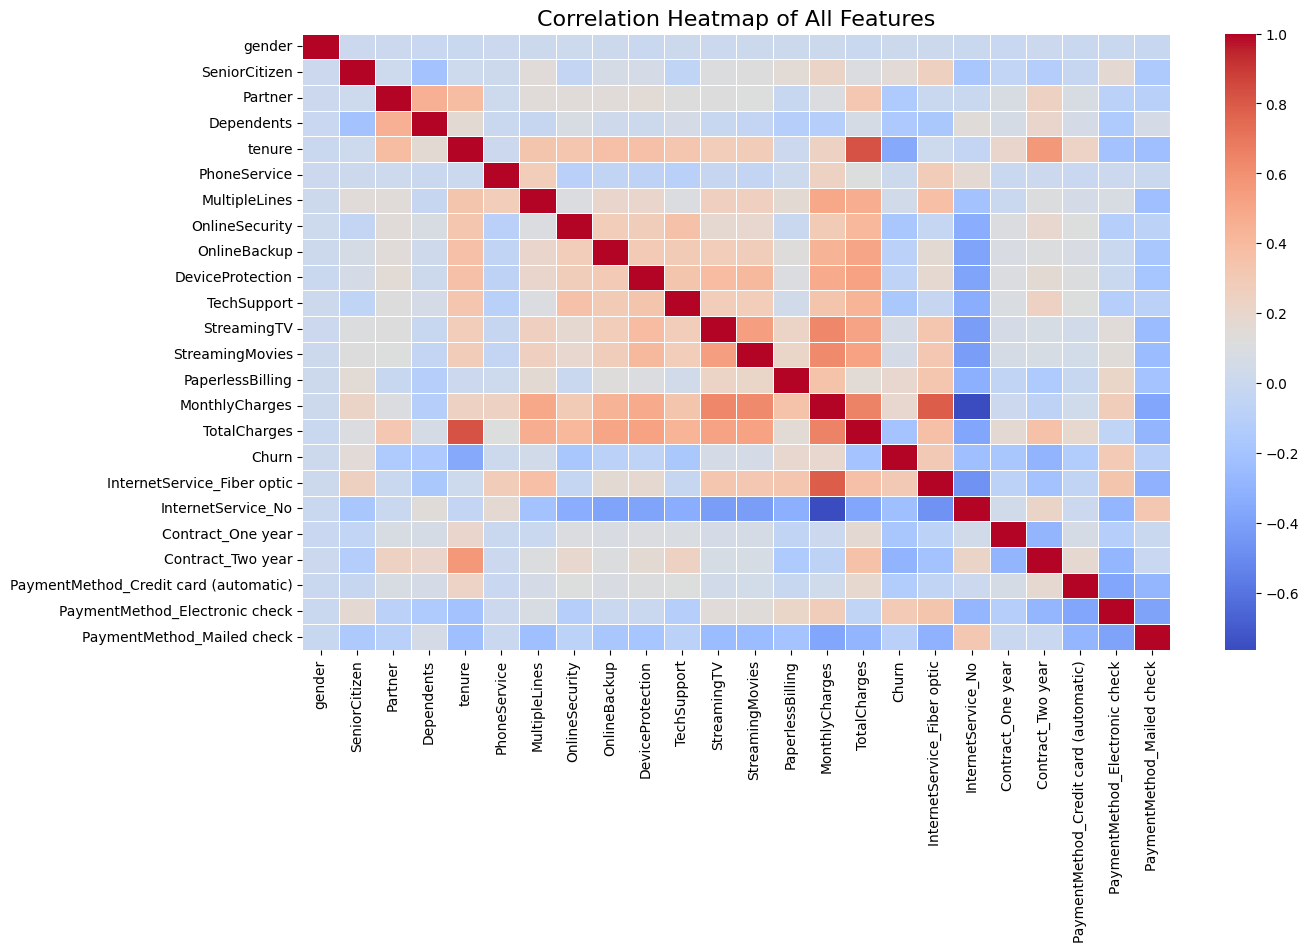

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
data_d = pd.get_dummies(data, columns=['InternetService','Contract','PaymentMethod'], drop_first=True)

# Correlation matrix
corr = data_d.corr()

# Heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(corr, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap of All Features", fontsize=16)
plt.show()

### **feature selection analysis**:

In [44]:
x= data_d.drop('Churn', axis=1)
y = data_d['Churn']


In [ ]:
from sklearn.feature_selection import VarianceThreshold


selector = VarianceThreshold(threshold=0.01)  # drop features with <1% variance
selector.fit(x)

low_var_cols = [col for col, var in zip(x.columns, selector.variances_) if var < 0.01]
print("Low variance features:", low_var_cols)
#

Low variance features: []


features have enough variability to be potentially useful for modeling.

#### correlation heatmap

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = x.corr()


# Identify highly correlated pairs
threshold = 0.9
corr_pairs = []
for i in corr.columns:
    for j in corr.columns:
        if i != j and abs(corr.loc[i,j]) > threshold:
            corr_pairs.append((i,j,corr.loc[i,j]))

print("Highly correlated pairs:", corr_pairs)


Highly correlated pairs: []


The correlation heatmap visualizes how strongly features are linearly related.
Highly correlated features (correlation > 0.9 or < -0.9) can cause multicollinearity issues in some models.
Here, 'corr_pairs' is empty, so there are no pairs of features with extremely high correlation.


#### **5. Correlation check**


Top 15 features by RandomForest importance:
 TotalCharges                      0.194826
MonthlyCharges                    0.181762
tenure                            0.176273
InternetService_Fiber optic       0.042527
PaymentMethod_Electronic check    0.037976
Contract_Two year                 0.030176
gender                            0.028592
PaperlessBilling                  0.027471
OnlineSecurity                    0.024126
TechSupport                       0.023838
Partner                           0.023573
Contract_One year                 0.022143
OnlineBackup                      0.021824
SeniorCitizen                     0.021072
Dependents                        0.019814
dtype: float64


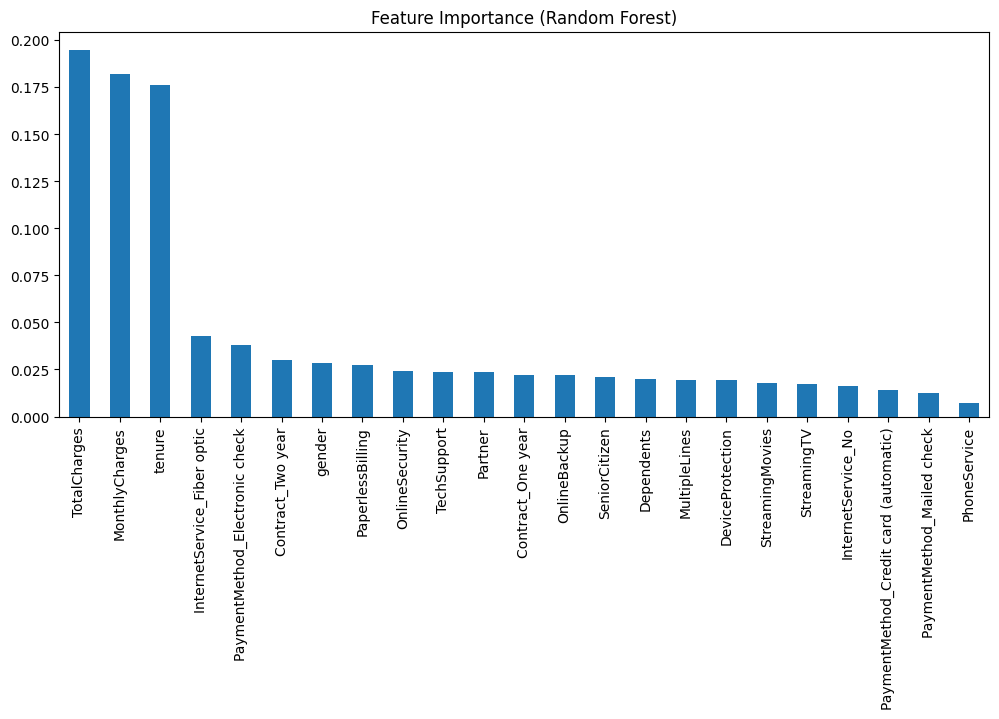

In [48]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
rf.fit(x, y)

importances = pd.Series(rf.feature_importances_, index=x.columns).sort_values(ascending=False)
print("\nTop 15 features by RandomForest importance:\n", importances.head(15))

importances.plot(kind='bar', figsize=(12,5), title="Feature Importance (Random Forest)")
plt.show()


The RandomForestClassifier ranks features by how much they contribute to predicting churn.
Top features: 'TotalCharges', 'MonthlyCharges', 'tenure', and service/contract/payment-related columns.
These features are most influential for the model's decisions.

In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

logreg = LogisticRegression(max_iter=1000, solver='liblinear')
rfe = RFE(logreg, n_features_to_select=15)  # keep 15 best features
rfe.fit(x, y)

selected_features = x.columns[rfe.support_]
print("\nSelected features by RFE:\n", selected_features.tolist())



Selected features by RFE:
 ['SeniorCitizen', 'Dependents', 'PhoneService', 'OnlineSecurity', 'OnlineBackup', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'InternetService_Fiber optic', 'InternetService_No', 'Contract_One year', 'Contract_Two year', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check']


RFE selects the 15 most predictive features for churn using a logistic regression model.
Selected features include tenure, service usage, contract type, and payment method.
These features provide a good balance between model simplicity and predictive power.





#### ✅ Conclusion

* The **top churn predictors** are billing/usage: `TotalCharges`, `MonthlyCharges`, `tenure`, contract type, internet service type, and payment method.
* **Extra services (security, backup, tech support)** act as retention factors.
* **Demographics have minimal impact** → don’t expect them to improve churn prediction.
* For modeling, start with **RFE’s 15 selected features**. That’s your optimal trade-off between predictive power and model simplicity.

The analyses confirm that billing, tenure, contract, and service-related features are the strongest predictors of churn. Demographic features have less impact. No features were dropped for low variance or high correlation.